In [1]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [5]:
%matplotlib inline

In [6]:
%%html
<style>
table {float:left;}
</style>

## Tool Modules

In [7]:
from quantum import *
from measurements import *

from unitary import *
from VQC import *

from dataSL import *
from QOLearner import *

from noise import *
from lipschitz import *

## Prepare Circuits

### - Input Circuits

In [8]:
def initCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    senders = circuit.qubits[0:n]
    receivers = circuit.qubits[n:]
    
    for sender, receiver in zip(senders, receivers):
        circuit.h(sender)
        circuit.cx(sender, receiver)
        
    return senders, receivers, circuit

In [9]:
def operate(circuit, target, bits):
    """
        => Z^(b_1) * X^(b_2)
    """
    if bits[0] == '1':
        circuit.z(target)
    if bits[1] == '1':
        circuit.x(target)

    return circuit

def getCircuit(n, classical_bits):
    bits_str = ''.join(classical_bits)
    """
        getCircuit(circuit, ["01", "10", "00"])
            => X(A1), Z(A2), I(A3)
    """
    senders, receivers, circuit = initCircuit(n)
    circuit_copy = circuit.copy()
    
    circuit_copy.barrier(senders)
    for i, sender in enumerate(senders):
        operate(circuit_copy, sender, classical_bits[i])

    return circuit_copy

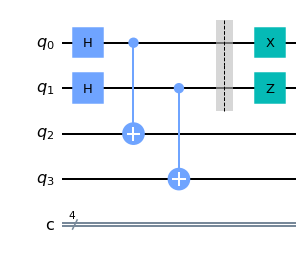

In [10]:
qc = getCircuit(2, ["01", "10"])
qc.draw(output='mpl')

In [11]:
inputCircuits = []
n = 2

classical_bits = ["00", "01", "10", "11"]
for comb in combs[n]:
    inputCircuits.append( getCircuit(n, list(map( lambda x: classical_bits[int(x)] , list(comb)))) )

print(len(inputCircuits)) # 16

16


### - Output Circuits

In [12]:
def getMeasureCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

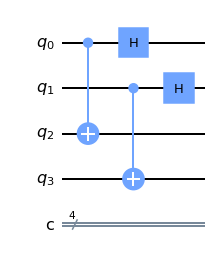

In [13]:
n = 2

measureCircuit = getMeasureCircuit(n)
measureCircuit.draw(output='mpl')

## Train paramters

In [14]:
import time
import sys
stdout = sys.stdout

In [15]:
# experiments times
MAX_TIMES = 10

### - expecetd

In [16]:
expected = {}

n = 2
for i in range(2 ** (2 * n)):
    expected[bin(i)[2:].rjust(2 * n, '0')] = 1

print(expected)
print(len(expected)) # 4 ** n

{'0000': 1, '0001': 1, '0010': 1, '0011': 1, '0100': 1, '0101': 1, '0110': 1, '0111': 1, '1000': 1, '1001': 1, '1010': 1, '1011': 1, '1100': 1, '1101': 1, '1110': 1, '1111': 1}
16


## Strategy: unitary

In [17]:
qol_unitary = QOLearnerBase([inputCircuits, measureCircuit], 2, [0, 1], expected)

In [122]:
times_unitary = []

for i in range(MAX_TIMES):
    sys.stdout = None
    start = time.clock()
    qol_unitary.fit(epoch=1000, strategy='unitary', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_unitary.append(end - start)
    sys.stdout = stdout
    
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_unitary.params[-1], 'sdc2', 'unitary', i + 1)
    saveLosses(qol_unitary.losses, 'sdc2', 'unitary', i + 1)

Fin - No. 1
Fin - No. 2
Fin - No. 3
Fin - No. 4
Fin - No. 5
Fin - No. 6
Fin - No. 7
Fin - No. 8
Fin - No. 9
Fin - No. 10


In [154]:
print(f'Average times for unitary: {np.mean(times_unitary)}')

Average times for unitary: 208.38560327000158


### - plot a loss example

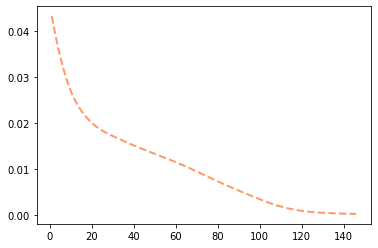

In [141]:
plot(loadLosses('sdc2', 'unitary', 9), color=palette['unitary'])

In [19]:
losses_unitary = []
max_length = 0
for i in range(MAX_TIMES):
    losses_unitary.append(loadLosses('sdc2', 'unitary', i + 1))
    max_length = max(max_length, len(losses_unitary[-1]))

for i in range(MAX_TIMES):
    length = len(losses_unitary[i])
    while length < max_length:
        losses_unitary[i].append(losses_unitary[i][-1])
        length += 1

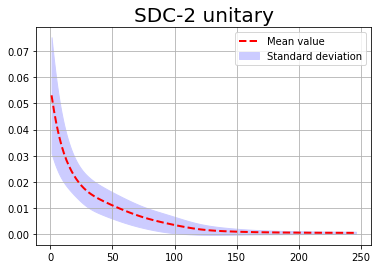

In [20]:
plotLosses(losses_unitary, title='SDC-2 unitary')

### - average time and loss

In [144]:
average_loss_unitary = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc2', 'unitary', i + 1)[-1]
    average_loss_unitary += loss
print(f'Average loss for unitary: {average_loss_unitary / MAX_TIMES}')

Average loss for unitary: (0.0005889372168244077+0j)


In [145]:
average_epoch_unitary = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc2', 'unitary', i + 1)
    average_epoch_unitary += len(loss)
print(f'Average epoch for unitary: {average_epoch_unitary / MAX_TIMES}')

Average epoch for unitary: 155.8


In [146]:
average_time_unitary = 208.38560327000158

In [147]:
average_time_per_epoch_unitary = average_time_unitary / average_epoch_unitary
print(f'Average time per epoch for unitary: {average_time_per_epoch_unitary}')

Average time per epoch for unitary: 0.1337519918292693


|Strategy| parameterized unitary |
|:----------------:|:-----:|
| Average loss | 5.889e-4 |
| Average time | 208.4 |
| Average epochs | 155.8 |
| Average time per epoch | 0.134 |

## Strategy: VQC

In [67]:
qol_vqc = QOLearnerBase([inputCircuits, measureCircuit], 2, [0, 1], expected)

In [123]:
times_vqc = []

for i in range(MAX_TIMES):
    sys.stdout = None
    start = time.clock()
    qol_vqc.fit(epoch=1000, strategy='vqc', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_vqc.append(end - start)
    sys.stdout = stdout
    
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_vqc.params[-1], 'sdc2', 'vqc', i + 1)
    saveLosses(qol_vqc.losses, 'sdc2', 'vqc', i + 1)

Fin - No. 1
Fin - No. 2
Fin - No. 3
Fin - No. 4
Fin - No. 5
Fin - No. 6
Fin - No. 7
Fin - No. 8
Fin - No. 9
Fin - No. 10


In [131]:
print(f'Average times for vqc: {np.mean(times_vqc)}')

Average times for vqc: 197.4960733400003


### - plot a loss example

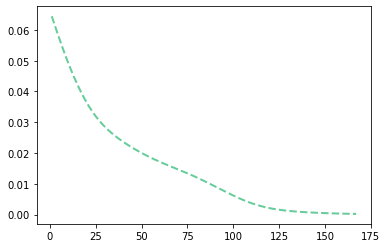

In [132]:
plot(loadLosses('sdc2', 'vqc', 6), color=palette['vqc'])

In [21]:
losses_vqc = []
max_length = 0
for i in range(10):
    losses_vqc.append(loadLosses('sdc2', 'vqc', i + 1))
    max_length = max(max_length, len(losses_vqc[-1]))

for i in range(10):
    length = len(losses_vqc[i])
    while length < max_length:
        losses_vqc[i].append(losses_vqc[i][-1])
        length += 1

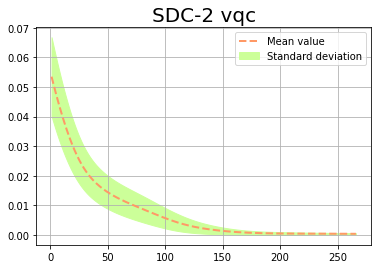

In [22]:
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="SDC-2 vqc")

### - average time and loss

In [135]:
average_loss_vqc = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc2', 'vqc', i + 1)[-1]
    average_loss_vqc += loss
print(f'Average loss for vqc: {average_loss_vqc / MAX_TIMES}')

Average loss for vqc: (0.0003660185362818955+0j)


In [136]:
average_epoch_vqc = 0
for i in range(MAX_TIMES):
    loss = loadLosses('sdc2', 'vqc', i + 1)
    average_epoch_vqc += len(loss)
print(f'Average epoch for vqc: {average_epoch_vqc / MAX_TIMES}')

Average epoch for vqc: 181.6


In [137]:
average_time_vqc = 197.4960733400003

In [138]:
average_time_per_epoch_vqc = average_time_vqc / average_epoch_vqc
print(f'Average time per epoch for vqc: {average_time_per_epoch_vqc}')

Average time per epoch for vqc: 0.10875334435022042


| Strategy | VQC |
|:----------------:|:-----:|
| Average loss | 3.660e-4 |
| Average time | 197.5 |
| Average epochs | 181.6 |
| Average time per epoch | 0.109 |

##  Summarize

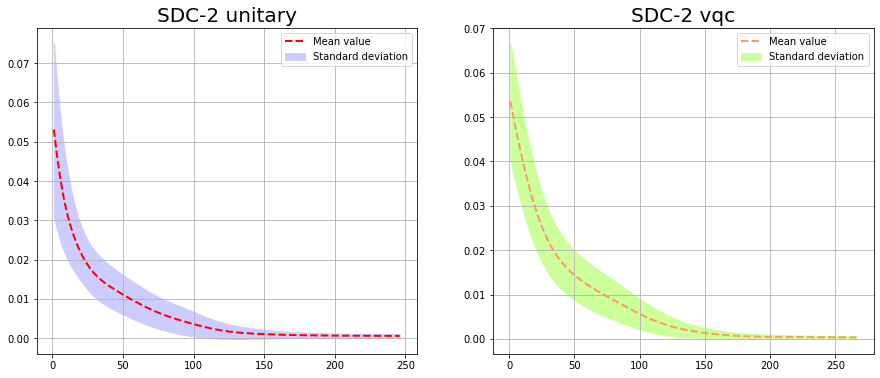

In [148]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plotLosses(losses_unitary, title="SDC-2 unitary")
plt.subplot(1,2,2)
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="SDC-2 vqc")

|Strategy| parameterized unitary | VQC |
|:----------------:|:-----:|:-----:|
| Average loss | 5.889e-4 | 3.660e-4 |
| Average time | 208.4 | 197.5 |
| Average epochs | 155.8 | 181.6 |
| Average time per epoch | 0.134 | 0.109 |

## Compare Lipschitz

In [18]:
measurements = getMeasurements(4)

In [19]:
names = ['unitary', 'vqc']

In [20]:
error_params = [
    [0.0001 , 'b'], [0.0001 , 'p'], [0.0001 , 'd'], 
    [0.001 , 'b'], [0.001 , 'p'], [0.001 , 'd'], 
    [0.01 , 'b'], [0.01 , 'p'], [0.01 , 'd'],
    [0.1 , 'b'], [0.1 , 'p'], [0.1 , 'd'], 
]

### - exact Lipschitz

In [21]:
smallestDict = { k: 0 for k in names }

for (p, errorType) in error_params:
    print(f' - p = {p}, errorType: {errorType}')
    
    # simulate noise input circuits
    noiseInputCircuits = getNoiseCircuits(inputCircuits, p, errorType)

    smallest = 1.0; smallestKey = ''
    for name in names: # unitary or vqc
        lip = 0.0
        
        for i in range(MAX_TIMES):
            # build targetCircuit
            params = loadParams('sdc2', name, i + 1)
            targetCircuit = QuantumCircuit(4, 4)
            
            if name == 'unitary':
                targetCircuit.append(buildU(2, params), [0, 1])
            else:
                targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])
                
            lip += calculateExactLipschitz2(
                inputCircuits, noiseInputCircuits, 
                targetCircuit, measureCircuit, measurements
            )
        lip = lip / MAX_TIMES
        
        if lip < smallest:
            smallest = lip
            smallestKey = name
        
        print(f'Lipschitz for [{name}] is: {lip}\n')
    
    smallestDict[smallestKey]  += 1.0
    print(f'smallest one: [{smallestKey}]')
        
    print('-' * 25)
    print()

print(smallestDict)

 - p = 0.0001, errorType: b
Lipschitz for [unitary] is: 0.017109645455904973

Lipschitz for [vqc] is: 0.009154627023146534

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: p
Lipschitz for [unitary] is: 0.017113706734255944

Lipschitz for [vqc] is: 0.009156384310283858

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: d
Lipschitz for [unitary] is: 0.017111940377537105

Lipschitz for [vqc] is: 0.00915543552554245

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: b
Lipschitz for [unitary] is: 0.01707316806099261

Lipschitz for [vqc] is: 0.009138873955796042

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: p
Lipschitz for [unitary] is: 0.01711370673275306

Lipschitz for [vqc] is: 0.009156384309011202

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: d
Lipschitz for [unitary] is: 0.017096056588320443

Lipschitz for [vqc] is: 0.009146912301708065

smallest one: [vqc]
-------

<table>
    <tr>
        <th style="text-align: center"  rowspan="2">Strategy</th><th style="text-align: center"rowspan="2">Error Type</th><th colspan="4" style="text-align: center">Probability</th>
    </tr>
    <tr>
                                                 <td style="text-align: center" >0.0001</td><td style="text-align: center" >0.001</td><td style="text-align: center" >0.01</td><td style="text-align: center" >0.1</td>
    </tr>
    <tr>
        <td style="text-align: center"  rowspan="3">PUG</td><td style="text-align: center" >bit flip</td><td style="text-align: center" >0.01711</td><td style="text-align: center" >0.01707</td><td style="text-align: center" >0.01672</td><td style="text-align: center" >0.01425</td>
    </tr>
    <tr>
        <td style="text-align: center" >phase flip</td><td style="text-align: center" >0.01711</td><td style="text-align: center" >0.01711</td><td style="text-align: center" >0.01711</td><td style="text-align: center" >0.01711</td>
    </tr>
    <tr>
        <td style="text-align: center" >depolarizing</td><td style="text-align: center" >0.01711</td><td style="text-align: center" >0.01710</td><td style="text-align: center" >0.01694</td><td style="text-align: center" >0.01560</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">VQC</td><td  style="text-align: center" >bit flip</td><td style="text-align: center" >9.155e-3</td><td style="text-align: center" >9.139e-3</td><td style="text-align: center" >8.988e-3</td><td style="text-align: center" >8.016e-3</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td style="text-align: center" >9.156e-3</td><td style="text-align: center" >9.156e-3</td><td style="text-align: center" >9.156e-3</td><td style="text-align: center" >9.156e-3</td>
    </tr>
    <tr>
        <td style="text-align: center" >depolarizing</td><td style="text-align: center" >9.155e-3</td><td style="text-align: center" >9.147e-3</td><td style="text-align: center" >9.063e-3</td><td style="text-align: center" >8.381e-3</td>
    </tr>
    
</table>

<table>
    <tr>
        <th style="text-align: center"  rowspan="2">Strategy</th><th style="text-align: center"rowspan="2">Error Type</th><th colspan="4" style="text-align: center">Probability</th>
    </tr>
    <tr>
                                                 <td style="text-align: center" >0.0001</td><td style="text-align: center" >0.001</td><td style="text-align: center" >0.01</td><td style="text-align: center" >0.1</td>
    </tr>
    <tr>
        <td style="text-align: center"  rowspan="3">Parameterized Unitary</td><td style="text-align: center" >bit flip</td><td style="text-align: center" >0.01533</td><td style="text-align: center" >0.01533</td><td style="text-align: center" >0.01529</td><td style="text-align: center" >0.01502</td>
    </tr>
    <tr>
        <td style="text-align: center" >phase flip</td><td style="text-align: center" >3.694e-14</td><td style="text-align: center" >1.762e-14</td><td style="text-align: center" >2.118e-15</td><td style="text-align: center" >2.087e-16</td>
    </tr>
    <tr>
        <td style="text-align: center" >depolarizing</td><td style="text-align: center" >8.021e-3</td><td style="text-align: center" >8.027e-3</td><td style="text-align: center" >8.085e-3</td><td style="text-align: center" >8.667e-3</td>
    </tr>
    <tr>
        <td style="text-align: center" rowspan="3">VQC</td><td  style="text-align: center" >bit flip</td><td style="text-align: center" >7.804e-3</td><td style="text-align: center" >7.803e-3</td><td style="text-align: center" >7.799e-3</td><td style="text-align: center" >7.771e-3</td>
    </tr>
    <tr>
        <td style="text-align: center">phase flip</td><td style="text-align: center" >2.192e-14</td><td style="text-align: center" >1.003e-14</td><td style="text-align: center" >1.243e-15</td><td style="text-align: center" >1.201e-16</td>
    </tr>
    <tr>
        <td style="text-align: center" >depolarizing</td><td style="text-align: center" >4.209e-3</td><td style="text-align: center" >4.212e-3</td><td style="text-align: center" >4.244e-3</td><td style="text-align: center" >4.571e-3</td>
    </tr>
    
</table>

### - approximate Lipschitz

In [153]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('sdc2', name, i + 1)
        targetCircuit = QuantumCircuit(4, 4)

        if name == 'unitary':
            targetCircuit.append(buildU(2, params), [0, 1])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])

        score = calculateLipschitz(targetCircuit, measureCircuit, measurements)
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
                                  
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: 0.026536907191988986(best params: No.9(7.218545981975993e-05))

Lipschitz for [vqc] is: 0.009256806191693273(best params: No.8(3.401474584273814e-06))



In [20]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('sdc2', name, i + 1)
        targetCircuit = QuantumCircuit(4, 4)

        if name == 'unitary':
            targetCircuit.append(buildU(2, params), [0, 1])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])

        score = calculateLipschitz2(targetCircuit, measureCircuit, measurements)
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
                                  
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: (0.026536907191988986+6.764828905028613e-20j)(best params: No.9((7.218545981975993e-05+9.238018107808892e-22j)))

Lipschitz for [vqc] is: (0.009256806191693273-1.1269060413117056e-20j)(best params: No.8((3.401474584273814e-06-3.214414997621512e-23j)))



In [20]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('sdc2', name, i + 1)
        targetCircuit = QuantumCircuit(4, 4)

        if name == 'unitary':
            targetCircuit.append(buildU(2, params), [0, 1])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])

        score = np.abs(calculateLipschitz2(targetCircuit, measureCircuit, measurements))
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
                                  
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: 0.026536907191988986(best params: No.9(7.218545981975993e-05))

Lipschitz for [vqc] is: 0.009256806191693273(best params: No.8(3.401474584273814e-06))

